# Úkol č. 2 - regrese

  * **Deadline je do 4. 12. 2022, 23:59:59**, pokud odevzdáte úkol do 11. 12. 2022, 23:59:59, budete penalizování -4 body, pozdější odevzdání je bez bodu.
  * V rámci tohoto úkolu se musíte vypořádat s problematikou regrese a hledání optimálních hyperparametrů.
    
> **Úkoly jsou zadány tak, aby Vám daly prostor pro invenci. Vymyslet _jak přesně_ budete úkol řešit, je důležitou součástí zadání a originalita či nápaditost bude také hodnocena!**

Využívejte buňky typu `Markdown` k vysvětlování Vašeho postupu. Za nepřehlednost budeme strhávat body.

## Zdroj dat

  * Zdrojem dat je soubor `LifeExpectancyData.csv` (originál zde: https://www.kaggle.com/kumarajarshi/life-expectancy-who).
  * Popis datasetu najdete na uvedené stránce s originálem datasetu.
  * Cílová (vysvětlovaná) proměnná se jmenuje `Life expectancy `.

## Pokyny k vypracování

**Body zadání**, za jejichž (poctivé) vypracování získáte **16 bodů**:
  * Odeberte z datasetu datové body, u kterých neznáte vysvětlovanou proměnnou.
  * Rozdělte data na vhodné podmnožiny, které Vám poslouží pro trénování, porovnávání modelů a následnou predikci výkonnosti finálního modelu.
  * Proveďte základní průzkum dat a svá pozorování diskutujte. Na jeho základě adekvátně reagujte na problematické věci v datech (chybějící hodnoty, atd.) a vysvětlete motivaci k provedeným krokům.
  * Aplikujte lineární a hřebenovou regresi a výsledky řádně vyhodnoťte:
      * K měření chyby použijte MAE (mean absolute error) a RMSE (root mean squared error).

  * Zkoumejte, jak byste mohli modely vylepšit:
      * Experimentujte s tvorbou nových příznaků (na základě těch dostupných).
      * Experimentujte se standardizací/normalizací dat.
      * Vyberte si hyperparametry modelů k ladění a najděte jejich nejlepší hodnoty.
      * Získané výsledky vždy řádně okomentujte.
    
  * Použijte i jiné modely (alespoň jeden) probírané v předmětu BI-ML1 či i jiné, pokud víte, jak fungují.
  * Nakonec vyberte nejlepší model (vzhledem k RMSE) a odhadněte, jakou RMSE a MAE můžete očekávat na nových datech, která jste doposud neměli k dispozici.

## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-ML1/homeworks/index.html.
  * Opravující Vám ve výjimečných případech může umožnit úkol dodělat či opravit a získat tak další body. První verze je ale stěžejní a má hlavní vliv na hodnocení.

### Import potřebných balíčků

In [1]:
# práce s datasetem
import pandas as pd
import numpy as np
# modely
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor

# machine-learning knihovna
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import sklearn.metrics as metrics
from scipy import optimize
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import LabelEncoder
# vizualizace
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker # Mřížka grafů
import seaborn as sb

### Načtení dat

In [2]:
df = pd.read_csv('LifeExpectancyData.csv')

#### Převedení sloupců na společný formát neobsahující nahodilé mezery a velká písmena

In [3]:
print("Před úpravou:")
display(df.columns)
df.rename(columns={'Life expectancy ':'Life expectancy', 'Measles ':'Measles', ' BMI ':'BMI', 'under-five deaths ':'Under-five Deaths', 'Diphtheria ':'Diphtheria', ' HIV/AIDS':'HIV/AIDS', ' thinness  1-19 years':'Thinness 1-19 Years', ' thinness 5-9 years':'Thinness 5-9 Years', 'percentage expenditure':'Percentage Expenditure', 'Income composition of resources':'Income Composition of Resources', 'Total expenditure':'Total Expenditure', 'infant deaths':'Infant Deaths' }, inplace=True)
print("Po úpravě:")
display(df.columns)

Před úpravou:


Index(['Country', 'Year', 'Status', 'Life expectancy ', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles ', ' BMI ', 'under-five deaths ', 'Polio', 'Total expenditure',
       'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population',
       ' thinness  1-19 years', ' thinness 5-9 years',
       'Income composition of resources', 'Schooling'],
      dtype='object')

Po úpravě:


Index(['Country', 'Year', 'Status', 'Life expectancy', 'Adult Mortality',
       'Infant Deaths', 'Alcohol', 'Percentage Expenditure', 'Hepatitis B',
       'Measles', 'BMI', 'Under-five Deaths', 'Polio', 'Total Expenditure',
       'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'Thinness 1-19 Years',
       'Thinness 5-9 Years', 'Income Composition of Resources', 'Schooling'],
      dtype='object')

### Odebrání bodů s chybějící vysvětlovanou proměnnou

In [4]:
print("Rozměry před úpravou:", df.shape)
tmp = df.shape[0]
df = df[df["Life expectancy"].notnull()]
print("Rozměry po úpravě:", df.shape)
print("Odebraných záznamů:", tmp-df.shape[0])

Rozměry před úpravou: (2938, 22)
Rozměry po úpravě: (2928, 22)
Odebraných záznamů: 10


# Průzkum dat

### Celkový pohled na data

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2928 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2928 non-null   object 
 1   Year                             2928 non-null   int64  
 2   Status                           2928 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   Infant Deaths                    2928 non-null   int64  
 6   Alcohol                          2735 non-null   float64
 7   Percentage Expenditure           2928 non-null   float64
 8   Hepatitis B                      2375 non-null   float64
 9   Measles                          2928 non-null   int64  
 10  BMI                              2896 non-null   float64
 11  Under-five Deaths                2928 non-null   int64  
 12  Polio               

In [6]:
df.describe(include='all')

,Country,Year,Status,Life expectancy,Adult Mortality,Infant Deaths,Alcohol,Percentage Expenditure,Hepatitis B,Measles,...,Polio,Total Expenditure,Diphtheria,HIV/AIDS,GDP,Population,Thinness 1-19 Years,Thinness 5-9 Years,Income Composition of Resources,Schooling
count,2928,2928.00000,2928,2928.000000,2928.000000,2928.000000,2735.000000,2928.000000,2375.000000,2928.000000,...,2909.000000,2702.000000,2909.000000,2928.000000,2485.000000,2.284000e+03,2896.000000,2896.000000,2768.000000,2768.000000
unique,183,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Afghanistan,NaN,Developing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,16,NaN,2416,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,2007.50000,NaN,69.224932,164.796448,30.407445,4.614856,740.321185,80.960842,2427.855874,...,82.548298,5.930163,82.321416,1.747712,7494.210719,1.276454e+07,4.850622,4.881423,0.627419,11.999639
std,NaN,4.61056,NaN,9.523867,124.292079,118.114450,4.050749,1990.930605,25.018337,11485.970937,...,23.416674,2.483273,23.706644,5.085542,14282.251492,6.103765e+07,4.420829,4.509609,0.210978,3.346440
min,NaN,2000.00000,NaN,36.300000,1.000000,0.000000,0.010000,0.000000,1.000000,0.000000,...,3.000000,0.370000,2.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,0.000000
25%,NaN,2003.75000,NaN,63.100000,74.000000,0.000000,0.905000,4.853964,77.000000,0.000000,...,78.000000,4.260000,78.000000,0.100000,463.852618,1.966738e+05,1.600000,1.575000,0.493000,10.100000
50%,NaN,2007.50000,NaN,72.100000,144.000000,3.000000,3.770000,65.611455,92.000000,17.000000,...,93.000000,5.750000,93.000000,0.100000,1764.973870,1.391756e+06,3.300000,3.400000,0.677000,12.300000
75%,NaN,2011.25000,NaN,75.700000,228.000000,22.000000,7.715000,442.614322,97.000000,362.250000,...,97.000000,7.490000,97.000000,0.800000,5932.899677,7.426746e+06,7.200000,7.200000,0.779250,14.300000


### Vysvětlovaná proměnná: `Life expectancy`

In [7]:
tmp = "Life expectancy"
print("Datový typ:", df[tmp].dtype)
print("Počet chybějících záznamů:", df[tmp].isnull().sum())
print("Počet unikátních hodnot:", df[tmp].nunique())
T = df[df[tmp].notnull()][tmp].sort_values().unique()
print("Rozsah hodnot:", T[0], "-", T[-1])
print("Průměr:", 69)
print("Medián:", 72)
df[tmp].describe()

Datový typ: float64
Počet chybějících záznamů: 0
Počet unikátních hodnot: 362
Rozsah hodnot: 36.3 - 89.0
Průměr: 69
Medián: 72


count    2928.000000
mean       69.224932
std         9.523867
min        36.300000
25%        63.100000
50%        72.100000
75%        75.700000
max        89.000000
Name: Life expectancy, dtype: float64

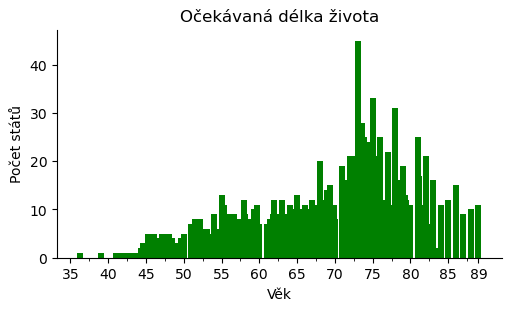

In [8]:
tmp = df["Life expectancy"].value_counts()
# nastavení figure
fig = plt.figure(figsize=(5,3), facecolor='white', constrained_layout=True)
# přidání místa pro graf
ax = fig.add_subplot()
# přidání grafu
ax.bar(tmp.index, tmp.values, color='green')
# přidání titulku
ax.set_title("Očekávaná délka života")
# přidání popisků os
ax.set_xlabel("Věk")
ax.set_ylabel("Počet států")
# nastavení správného měřítka
locator1 = ticker.FixedLocator([x for x in range(int(max(tmp.index))) if x % 5 == 0] + [max(tmp.index)])
ax.xaxis.set_major_locator(locator1)
locator2 = ticker.FixedLocator([x for x in np.arange(35, 89, 2.5)])
ax.xaxis.set_minor_locator(locator2)
# odebrání zbytečných ohraničení
ax.spines['top'].set_visible(False) 
ax.spines['right'].set_visible(False)

### Základní průzkum příznaků

Country

In [9]:
tmp = "Country"
print("Datový typ:", df[tmp].dtype)
print("Počet chybějících záznamů:", df[tmp].isnull().sum())
print("Počet unikátních hodnot:", df[tmp].nunique())
T = df[df[tmp].notnull()][tmp].sort_values().unique()
print("První záznam:", T[0])
print("Poslední záznam:", T[-1])
df[tmp].describe()

Datový typ: object
Počet chybějících záznamů: 0
Počet unikátních hodnot: 183
První záznam: Afghanistan
Poslední záznam: Zimbabwe


count            2928
unique            183
top       Afghanistan
freq               16
Name: Country, dtype: object

Year

In [10]:
tmp = "Year"
print("Datový typ:", df[tmp].dtype)
print("Počet chybějících záznamů:", df[tmp].isnull().sum())
print("Počet unikátních hodnot:", df[tmp].nunique())
T = df[df[tmp].notnull()][tmp].sort_values().unique()
print("Rozsah hodnot:", T[0], "-", T[-1])
df[tmp].describe()

Datový typ: int64
Počet chybějících záznamů: 0
Počet unikátních hodnot: 16
Rozsah hodnot: 2000 - 2015


count    2928.00000
mean     2007.50000
std         4.61056
min      2000.00000
25%      2003.75000
50%      2007.50000
75%      2011.25000
max      2015.00000
Name: Year, dtype: float64

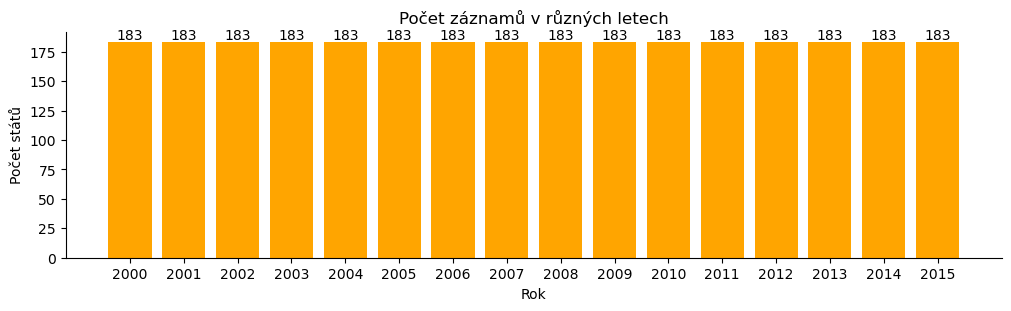

In [11]:
tmp = df["Year"].value_counts()
# nastavení figure
fig = plt.figure(figsize=(10,3), facecolor='white', constrained_layout=True)
# přidání místa pro graf
ax = fig.add_subplot()
# přidání grafu
react = ax.bar(tmp.index, tmp.values, color='orange')
ax.bar_label(react)
# upravení měřítka grafu
locator1 = ticker.FixedLocator([x for x in range(2000, 2016)])
ax.xaxis.set_major_locator(locator1)
# přidání titulku
ax.set_title("Počet záznamů v různých letech")
# přidání popisků os
ax.set_xlabel("Rok")
ax.set_ylabel("Počet států")
# odebrání zbytečných ohraničení
ax.spines['top'].set_visible(False) 
ax.spines['right'].set_visible(False)

Status

In [12]:
tmp = "Status"
print("Datový typ:", df[tmp].dtype)
print("Počet chybějících záznamů:", df[tmp].isnull().sum())
print("Počet unikátních hodnot:", df[tmp].nunique())
T = df[df[tmp].notnull()][tmp].sort_values().unique()
print("Hodnoty:", T[0], ",", T[-1])
df[tmp].describe()

Datový typ: object
Počet chybějících záznamů: 0
Počet unikátních hodnot: 2
Hodnoty: Developed , Developing


count           2928
unique             2
top       Developing
freq            2416
Name: Status, dtype: object

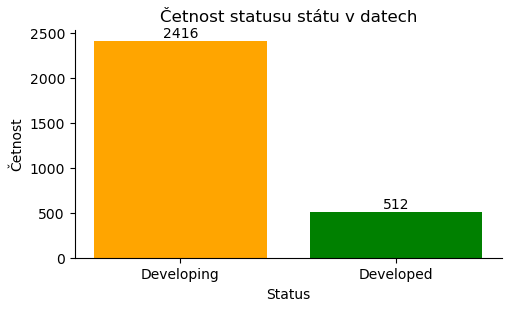

In [13]:
tmp = df["Status"].value_counts()
# nastavení figure
fig = plt.figure(figsize=(5,3), facecolor='white', constrained_layout=True)
# přidání místa pro graf
ax = fig.add_subplot()
# přidání grafu
react = ax.bar(tmp.index, tmp.values, color=['orange','green'])
ax.bar_label(react)
# přidání titulku
ax.set_title("Četnost statusu státu v datech")
# přidání popisků os
ax.set_xlabel("Status")
ax.set_ylabel("Četnost")
# odebrání zbytečných ohraničení
ax.spines['top'].set_visible(False) 
ax.spines['right'].set_visible(False)

Adult mortality

In [14]:
tmp = "Adult Mortality"
print("Datový typ:", df[tmp].dtype)
print("Počet chybějících záznamů:", df[tmp].isnull().sum())
print("Počet unikátních hodnot:", df[tmp].nunique())
T = df[df[tmp].notnull()][tmp].sort_values().unique()
print("Rozsah hodnot:", T[0], "-", T[-1])
print("Průměr:", 164)
print("Medián:", 144)
df[tmp].describe()

Datový typ: float64
Počet chybějících záznamů: 0
Počet unikátních hodnot: 425
Rozsah hodnot: 1.0 - 723.0
Průměr: 164
Medián: 144


count    2928.000000
mean      164.796448
std       124.292079
min         1.000000
25%        74.000000
50%       144.000000
75%       228.000000
max       723.000000
Name: Adult Mortality, dtype: float64

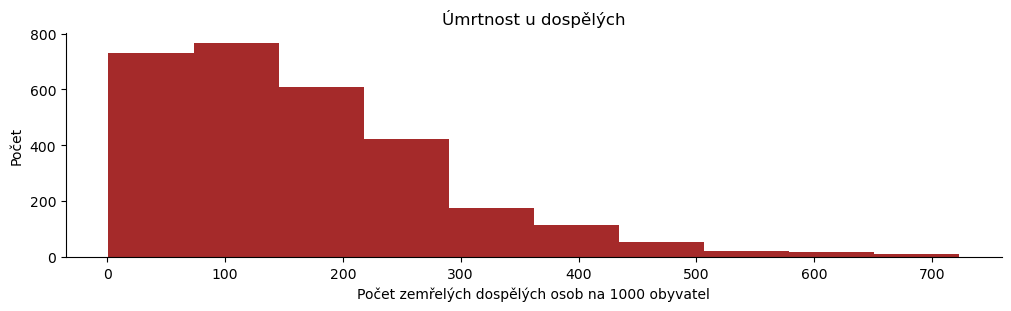

In [15]:
tmp = df["Adult Mortality"]
# nastavení figure
fig = plt.figure(figsize=(10,3), facecolor='white', constrained_layout=True)
# přidání místa pro graf
ax = fig.add_subplot()
# přidání grafu
ax.hist(tmp, color='brown')
# přidání titulku
ax.set_title("Úmrtnost u dospělých")
# přidání popisků os
ax.set_xlabel("Počet zemřelých dospělých osob na 1000 obyvatel")
ax.set_ylabel("Počet")
# nastavení správného měřítka
# odebrání zbytečných ohraničení
ax.spines['top'].set_visible(False) 
ax.spines['right'].set_visible(False)

Infant deaths

In [16]:
tmp = "Infant Deaths"
print("Datový typ:", df[tmp].dtype)
print("Počet chybějících záznamů:", df[tmp].isnull().sum())
print("Počet unikátních hodnot:", df[tmp].nunique())
T = df[df[tmp].notnull()][tmp].sort_values().unique()
print("Rozsah hodnot:", T[0], "-", T[-1])
print("Průměr:", 30)
print("Medián:", 3)
df[tmp].describe()

Datový typ: int64
Počet chybějících záznamů: 0
Počet unikátních hodnot: 209
Rozsah hodnot: 0 - 1800
Průměr: 30
Medián: 3


count    2928.000000
mean       30.407445
std       118.114450
min         0.000000
25%         0.000000
50%         3.000000
75%        22.000000
max      1800.000000
Name: Infant Deaths, dtype: float64

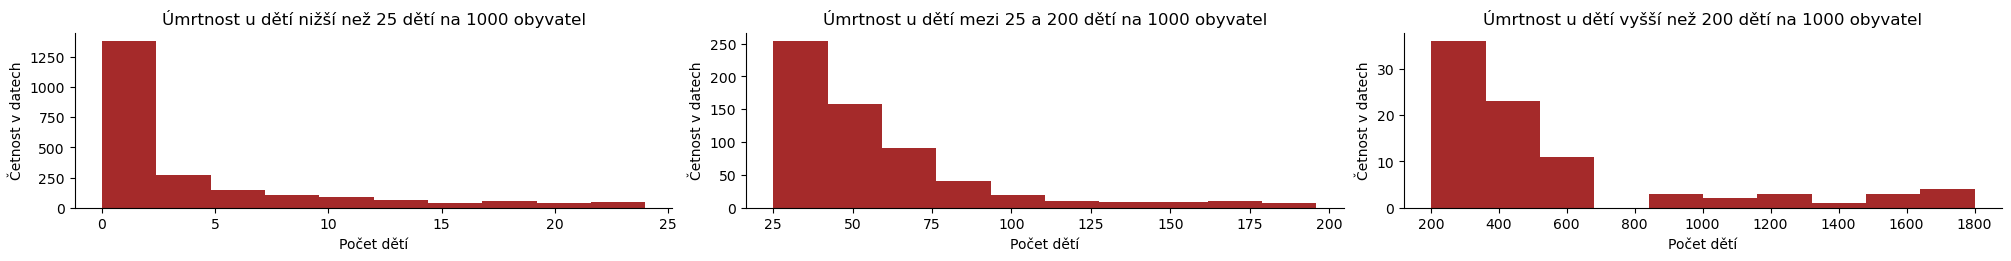

In [17]:
tmp1 = df[df[tmp] < 25][tmp]
tmp2 = df[ (df[tmp] < 200) & (df[tmp] >= 25) ][tmp]
tmp3 = df[df[tmp] >= 200][tmp]

# nastavení figure
fig = plt.figure(figsize=(20, 6), facecolor='white', constrained_layout=True)
# GRAF 1
# přidání místa pro graf
ax1 = fig.add_subplot(3, 3, 1)
# přidání grafu
ax1.hist(tmp1, color='brown')
# přidání titulku
ax1.set_title("Úmrtnost u dětí nižší než 25 dětí na 1000 obyvatel")
# přidání popisků os
ax1.set_xlabel("Počet dětí")
ax1.set_ylabel("Četnost v datech")
# nastavení správného měřítka
# odebrání zbytečných ohraničení
ax1.spines['top'].set_visible(False) 
ax1.spines['right'].set_visible(False)

# GRAF 2
ax2 = fig.add_subplot(3, 3, 2)
# přidání grafu
ax2.hist(tmp2, color='brown')
# přidání titulku
ax2.set_title("Úmrtnost u dětí mezi 25 a 200 dětí na 1000 obyvatel")
# přidání popisků os
ax2.set_xlabel("Počet dětí")
ax2.set_ylabel("Četnost v datech")
# nastavení správného měřítka
# odebrání zbytečných ohraničení
ax2.spines['top'].set_visible(False) 
ax2.spines['right'].set_visible(False)

# GRAF 3
ax3 = fig.add_subplot(3, 3, 3)
# přidání grafu
ax3.hist(tmp3, color='brown')
# přidání titulku
ax3.set_title("Úmrtnost u dětí vyšší než 200 dětí na 1000 obyvatel")
# přidání popisků os
ax3.set_xlabel("Počet dětí")
ax3.set_ylabel("Četnost v datech")
# nastavení správného měřítka
# odebrání zbytečných ohraničení
ax3.spines['top'].set_visible(False) 
ax3.spines['right'].set_visible(False)

Alcohol

In [18]:
tmp = "Alcohol"
print("Datový typ:", df[tmp].dtype)
print("Počet chybějících záznamů:", df[tmp].isnull().sum())
print("Počet unikátních hodnot:", df[tmp].nunique())
T = df[df[tmp].notnull()][tmp].sort_values().unique()
print("Rozsah hodnot:", T[0], "-", T[-1])
print("Průměr:", 4.6)
print("Medián:", 3.8)
print("Podíl záznamů se spotřebou alkoholu menší než 0.1: {}%".format(round(len(df[df["Alcohol"] < 0.1]) / len(df["Alcohol"]) * 100, 1)), )
df[tmp].describe()

Datový typ: float64
Počet chybějících záznamů: 193
Počet unikátních hodnot: 1076
Rozsah hodnot: 0.01 - 17.87
Průměr: 4.6
Medián: 3.8
Podíl záznamů se spotřebou alkoholu menší než 0.1: 12.4%


count    2735.000000
mean        4.614856
std         4.050749
min         0.010000
25%         0.905000
50%         3.770000
75%         7.715000
max        17.870000
Name: Alcohol, dtype: float64

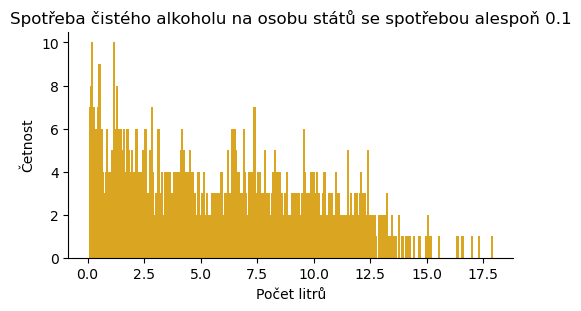

In [19]:
tmp = df[df["Alcohol"] >= 0.1]["Alcohol"].value_counts()
portion = tmp.index
# nastavení figure
fig = plt.figure(figsize=(5,3), facecolor='white', constrained_layout=True)
# přidání místa pro graf
ax = fig.add_subplot()
# přidání grafu
ax.bar(tmp.index, tmp.values, color='goldenrod', width=0.1)
# přidání titulku
ax.set_title("Spotřeba čistého alkoholu na osobu států se spotřebou alespoň 0.1")
# přidání popisků os
ax.set_xlabel("Počet litrů")
ax.set_ylabel("Četnost")
# odebrání zbytečných ohraničení
ax.spines['top'].set_visible(False) 
ax.spines['right'].set_visible(False)

Percentage expenditure

In [20]:
tmp = "Percentage Expenditure"
print("Datový typ:", df[tmp].dtype)
print("Počet chybějících záznamů:", df[tmp].isnull().sum())
print("Počet unikátních hodnot:", df[tmp].nunique())
T = df[df[tmp].notnull()][tmp].sort_values().unique()
print("Rozsah hodnot:", T[0], "-", T[-1])
print("Průměr:", 738)
print("Medián:", 65)
df[tmp].describe()

Datový typ: float64
Počet chybějících záznamů: 0
Počet unikátních hodnot: 2323
Rozsah hodnot: 0.0 - 19479.91161
Průměr: 738
Medián: 65


count     2928.000000
mean       740.321185
std       1990.930605
min          0.000000
25%          4.853964
50%         65.611455
75%        442.614322
max      19479.911610
Name: Percentage Expenditure, dtype: float64

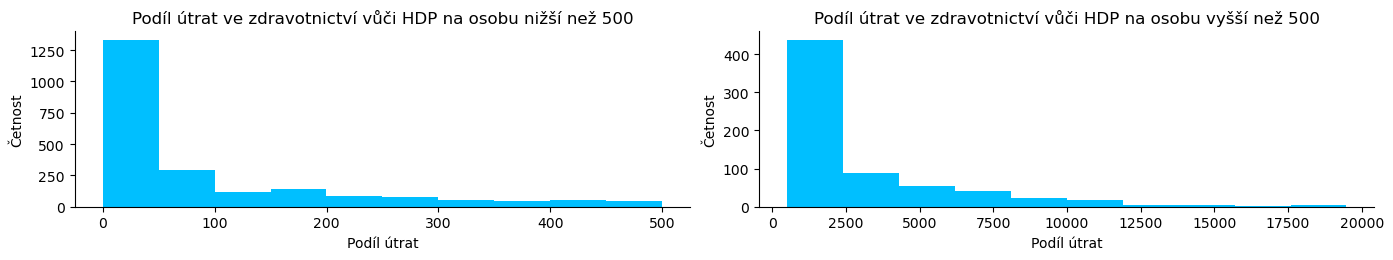

In [21]:
tmp1 = df[df["Percentage Expenditure"] < 500][tmp]
tmp2 = df[df[tmp] >= 500][tmp]

# nastavení figure
fig = plt.figure(figsize=(20, 6), facecolor='white', constrained_layout=True)
# GRAF 1
# přidání místa pro graf
ax1 = fig.add_subplot(3, 3, 1)
# přidání grafu
ax1.hist(tmp1, color='deepskyblue')
# přidání titulku
ax1.set_title("Podíl útrat ve zdravotnictví vůči HDP na osobu nižší než 500")
# přidání popisků os
ax1.set_xlabel("Podíl útrat")
ax1.set_ylabel("Četnost")
# nastavení správného měřítka
# odebrání zbytečných ohraničení
ax1.spines['top'].set_visible(False) 
ax1.spines['right'].set_visible(False)

# GRAF 2
ax2 = fig.add_subplot(3, 3, 2)
# přidání grafu
ax2.hist(tmp2, color='deepskyblue')
# přidání titulku
ax2.set_title("Podíl útrat ve zdravotnictví vůči HDP na osobu vyšší než 500")
# přidání popisků os
ax2.set_xlabel("Podíl útrat")
ax2.set_ylabel("Četnost")
# nastavení správného měřítka
# odebrání zbytečných ohraničení
ax2.spines['top'].set_visible(False) 
ax2.spines['right'].set_visible(False)

Hepatitis B

In [22]:
tmp = "Hepatitis B"
print("Datový typ:", df[tmp].dtype)
print("Počet chybějících záznamů:", df[tmp].isnull().sum())
print("Počet unikátních hodnot:", df[tmp].nunique())
T = df[df[tmp].notnull()][tmp].sort_values().unique()
print("Rozsah hodnot:", T[0], "-", T[-1])
print("Průměr:", 80)
print("Medián:", 92)
df[tmp].describe()

Datový typ: float64
Počet chybějících záznamů: 553
Počet unikátních hodnot: 87
Rozsah hodnot: 1.0 - 99.0
Průměr: 80
Medián: 92


count    2375.000000
mean       80.960842
std        25.018337
min         1.000000
25%        77.000000
50%        92.000000
75%        97.000000
max        99.000000
Name: Hepatitis B, dtype: float64

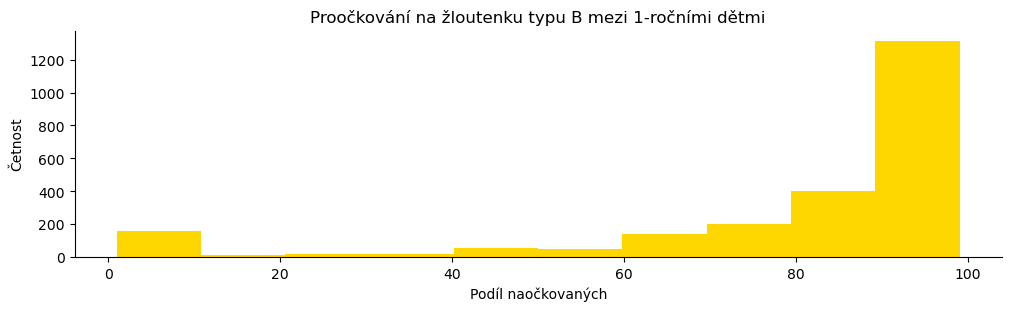

In [23]:
tmp = df["Hepatitis B"]
# nastavení figure
fig = plt.figure(figsize=(10,3), facecolor='white', constrained_layout=True)
# přidání místa pro graf
ax = fig.add_subplot()
# přidání grafu
ax.hist(tmp, color='gold')
# přidání titulku
ax.set_title("Proočkování na žloutenku typu B mezi 1-ročními dětmi")
# přidání popisků os
ax.set_xlabel("Podíl naočkovaných")
ax.set_ylabel("Četnost")
# nastavení správného měřítka
# odebrání zbytečných ohraničení
ax.spines['top'].set_visible(False) 
ax.spines['right'].set_visible(False)

Measles

In [24]:
tmp = "Measles"
print("Datový typ:", df[tmp].dtype)
print("Počet chybějících záznamů:", df[tmp].isnull().sum())
print("Počet unikátních hodnot:", df[tmp].nunique())
T = df[df[tmp].notnull()][tmp].sort_values().unique()
print("Rozsah hodnot:", T[0], "-", T[-1])
print("Průměr:", 2420)
print("Medián:", 17)
print("Podíl záznamů bez případů spalniček: {}%".format(round(len(df[df["Measles"] == 0]) / len(df["Measles"]) * 100, 1)))
df[tmp].describe()

Datový typ: int64
Počet chybějících záznamů: 0
Počet unikátních hodnot: 958
Rozsah hodnot: 0 - 212183
Průměr: 2420
Medián: 17
Podíl záznamů bez případů spalniček: 33.2%


count      2928.000000
mean       2427.855874
std       11485.970937
min           0.000000
25%           0.000000
50%          17.000000
75%         362.250000
max      212183.000000
Name: Measles, dtype: float64

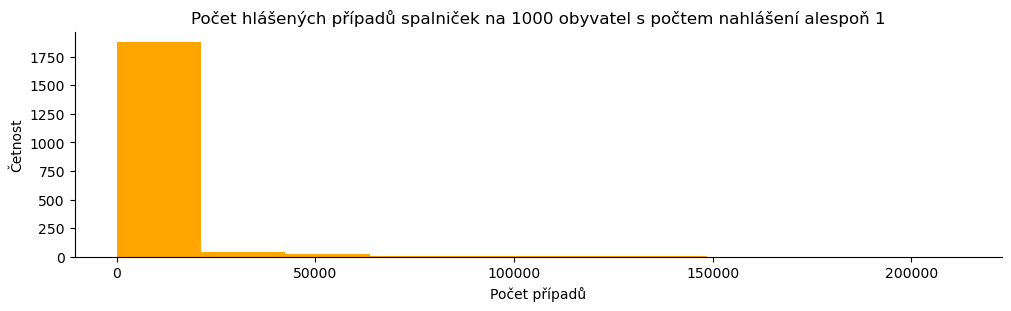

In [25]:
tmp = df[df["Measles"] > 0]["Measles"]
# nastavení figure
fig = plt.figure(figsize=(10,3), facecolor='white', constrained_layout=True)
# přidání místa pro graf
ax = fig.add_subplot()
# přidání grafu
ax.hist(tmp, color='orange')
# přidání titulku
ax.set_title("Počet hlášených případů spalniček na 1000 obyvatel s počtem nahlášení alespoň 1")
# přidání popisků os
ax.set_xlabel("Počet případů")
ax.set_ylabel("Četnost")
# nastavení správného měřítka
# odebrání zbytečných ohraničení
ax.spines['top'].set_visible(False) 
ax.spines['right'].set_visible(False)

BMI

In [26]:
tmp = "BMI"
print("Datový typ:", df[tmp].dtype)
print("Počet chybějících záznamů:", df[tmp].isnull().sum())
print("Počet unikátních hodnot:", df[tmp].nunique())
T = df[df[tmp].notnull()][tmp].sort_values().unique()
print("Rozsah hodnot:", T[0], "-", T[-1])
print("Průměr:", 38)
print("Medián:", 43)
df[tmp].describe()

Datový typ: float64
Počet chybějících záznamů: 32
Počet unikátních hodnot: 602
Rozsah hodnot: 1.0 - 77.6
Průměr: 38
Medián: 43


count    2896.000000
mean       38.235394
std        19.959590
min         1.000000
25%        19.300000
50%        43.350000
75%        56.100000
max        77.600000
Name: BMI, dtype: float64

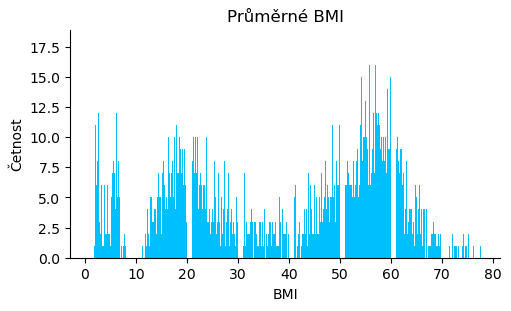

In [27]:
tmp = df["BMI"].value_counts()
portion = tmp.index
# nastavení figure
fig = plt.figure(figsize=(5,3), facecolor='white', constrained_layout=True)
# přidání místa pro graf
ax = fig.add_subplot()
# přidání grafu
ax.bar(tmp.index, tmp.values, color='deepskyblue', width=0.1)
# přidání titulku
ax.set_title("Průměrné BMI")
# přidání popisků os
ax.set_xlabel("BMI")
ax.set_ylabel("Četnost")
# odebrání zbytečných ohraničení
ax.spines['top'].set_visible(False) 
ax.spines['right'].set_visible(False)

Under-five deaths

In [28]:
tmp = "Under-five Deaths"
print("Datový typ:", df[tmp].dtype)
print("Počet chybějících záznamů:", df[tmp].isnull().sum())
print("Počet unikátních hodnot:", df[tmp].nunique())
T = df[df[tmp].notnull()][tmp].sort_values().unique()
print("Rozsah hodnot:", T[0], "-", T[-1])
print("Průměr:", 42)
print("Medián:", 4)
print("Podíl záznamů bez případů úmrtí dětí: {}%".format(round(len(df[df[tmp] == 0]) / len(df[tmp]) * 100, 1)))
df[tmp].describe()

Datový typ: int64
Počet chybějících záznamů: 0
Počet unikátních hodnot: 252
Rozsah hodnot: 0 - 2500
Průměr: 42
Medián: 4
Podíl záznamů bez případů úmrtí dětí: 26.5%


count    2928.000000
mean       42.179303
std       160.700547
min         0.000000
25%         0.000000
50%         4.000000
75%        28.000000
max      2500.000000
Name: Under-five Deaths, dtype: float64

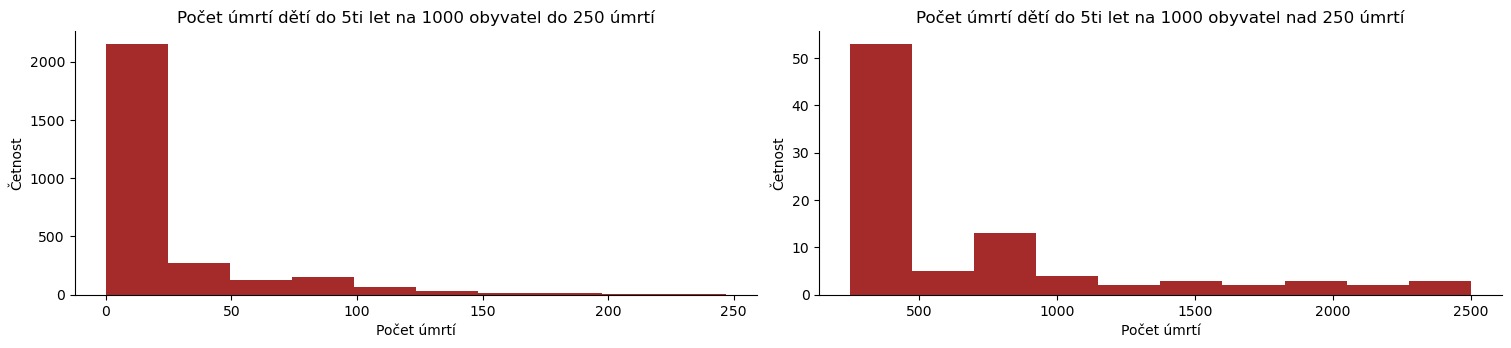

In [29]:
tmp = "Under-five Deaths"
tmp1 = df[df[tmp] <= 250][tmp]
tmp2 = df[(df[tmp] > 250)][tmp]

# nastavení figure
fig = plt.figure(figsize=(15, 6), facecolor='white', constrained_layout=True)
# GRAF 1
# přidání místa pro graf
ax1 = fig.add_subplot(2, 2, 1)
# přidání grafu
ax1.hist(tmp1, color='brown')
# přidání titulku
ax1.set_title("Počet úmrtí dětí do 5ti let na 1000 obyvatel do 250 úmrtí")
# přidání popisků os
ax1.set_xlabel("Počet úmrtí")
ax1.set_ylabel("Četnost")
# nastavení správného měřítka
# odebrání zbytečných ohraničení
ax1.spines['top'].set_visible(False) 
ax1.spines['right'].set_visible(False)

# GRAF 2
ax2 = fig.add_subplot(2, 2, 2)
# přidání grafu
ax2.hist(tmp2, color='brown')
# přidání titulku
ax2.set_title("Počet úmrtí dětí do 5ti let na 1000 obyvatel nad 250 úmrtí")
# přidání popisků os
ax2.set_xlabel("Počet úmrtí")
ax2.set_ylabel("Četnost")
# nastavení správného měřítka
# odebrání zbytečných ohraničení
ax2.spines['top'].set_visible(False) 
ax2.spines['right'].set_visible(False)

Polio

In [30]:
tmp = "Polio"
print("Datový typ:", df[tmp].dtype)
print("Počet chybějících záznamů:", df[tmp].isnull().sum())
print("Počet unikátních hodnot:", df[tmp].nunique())
T = df[df[tmp].notnull()][tmp].sort_values().unique()
print("Rozsah hodnot:", T[0], "-", T[-1])
print("Průměr:", 82)
print("Medián:", 93)
df[tmp].describe()

Datový typ: float64
Počet chybějících záznamů: 19
Počet unikátních hodnot: 73
Rozsah hodnot: 3.0 - 99.0
Průměr: 82
Medián: 93


count    2909.000000
mean       82.548298
std        23.416674
min         3.000000
25%        78.000000
50%        93.000000
75%        97.000000
max        99.000000
Name: Polio, dtype: float64

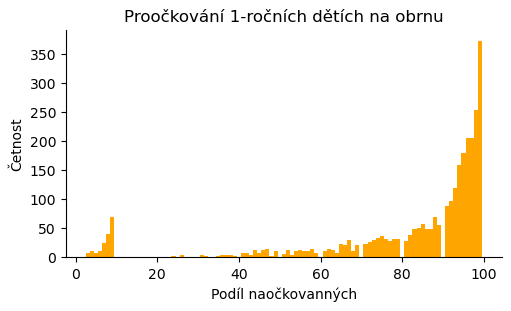

In [31]:
tmp = df["Polio"].value_counts()
portion = tmp.index
# nastavení figure
fig = plt.figure(figsize=(5,3), facecolor='white', constrained_layout=True)
# přidání místa pro graf
ax = fig.add_subplot()
# přidání grafu
ax.bar(tmp.index, tmp.values, color='orange', width=1)
# přidání titulku
ax.set_title("Proočkování 1-ročních dětích na obrnu")
# přidání popisků os
ax.set_xlabel("Podíl naočkovanných")
ax.set_ylabel("Četnost")
# odebrání zbytečných ohraničení
ax.spines['top'].set_visible(False) 
ax.spines['right'].set_visible(False)

Total expenditure

In [32]:
tmp = "Total Expenditure"
print("Datový typ:", df[tmp].dtype)
print("Počet chybějících záznamů:", df[tmp].isnull().sum())
print("Počet unikátních hodnot:", df[tmp].nunique())
T = df[df[tmp].notnull()][tmp].sort_values().unique()
print("Rozsah hodnot:", T[0], "-", T[-1])
print("Průměr:", 6)
print("Medián:", 5.7)
df[tmp].describe()

Datový typ: float64
Počet chybějících záznamů: 226
Počet unikátních hodnot: 816
Rozsah hodnot: 0.37 - 17.6
Průměr: 6
Medián: 5.7


count    2702.000000
mean        5.930163
std         2.483273
min         0.370000
25%         4.260000
50%         5.750000
75%         7.490000
max        17.600000
Name: Total Expenditure, dtype: float64

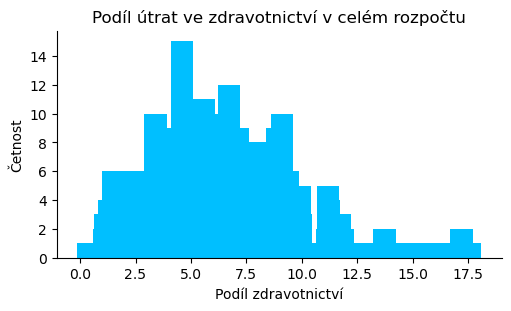

In [33]:
tmp = df["Total Expenditure"].value_counts()
portion = tmp.index
# nastavení figure
fig = plt.figure(figsize=(5,3), facecolor='white', constrained_layout=True)
# přidání místa pro graf
ax = fig.add_subplot()
# přidání grafu
ax.bar(tmp.index, tmp.values, color='deepskyblue', width=1)
# přidání titulku
ax.set_title("Podíl útrat ve zdravotnictví v celém rozpočtu")
# přidání popisků os
ax.set_xlabel("Podíl zdravotnictví")
ax.set_ylabel("Četnost")
# odebrání zbytečných ohraničení
ax.spines['top'].set_visible(False) 
ax.spines['right'].set_visible(False)

Diphtheria

In [34]:
tmp = "Diphtheria"
print("Datový typ:", df[tmp].dtype)
print("Počet chybějících záznamů:", df[tmp].isnull().sum())
print("Počet unikátních hodnot:", df[tmp].nunique())
T = df[df[tmp].notnull()][tmp].sort_values().unique()
print("Rozsah hodnot:", T[0], "-", T[-1])
print("Průměr:", 82)
print("Medián:", 93)
df[tmp].describe()

Datový typ: float64
Počet chybějících záznamů: 19
Počet unikátních hodnot: 81
Rozsah hodnot: 2.0 - 99.0
Průměr: 82
Medián: 93


count    2909.000000
mean       82.321416
std        23.706644
min         2.000000
25%        78.000000
50%        93.000000
75%        97.000000
max        99.000000
Name: Diphtheria, dtype: float64

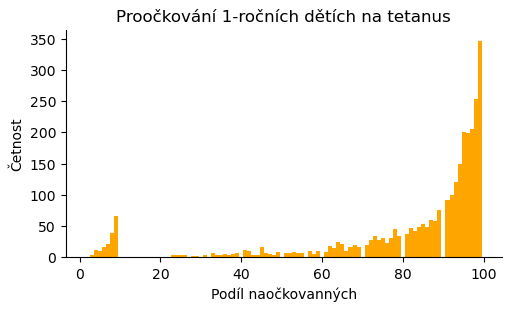

In [35]:
tmp = df["Diphtheria"].value_counts()
portion = tmp.index
# nastavení figure
fig = plt.figure(figsize=(5,3), facecolor='white', constrained_layout=True)
# přidání místa pro graf
ax = fig.add_subplot()
# přidání grafu
ax.bar(tmp.index, tmp.values, color='orange', width=1)
# přidání titulku
ax.set_title("Proočkování 1-ročních dětích na tetanus")
# přidání popisků os
ax.set_xlabel("Podíl naočkovanných")
ax.set_ylabel("Četnost")
# odebrání zbytečných ohraničení
ax.spines['top'].set_visible(False) 
ax.spines['right'].set_visible(False)

HIV/AIDS

In [36]:
tmp = "HIV/AIDS"
print("Datový typ:", df[tmp].dtype)
print("Počet chybějících záznamů:", df[tmp].isnull().sum())
print("Počet unikátních hodnot:", df[tmp].nunique())
T = df[df[tmp].notnull()][tmp].sort_values().unique()
print("Rozsah hodnot:", T[0], "-", T[-1])
print("Průměr:", 1.74)
print("Medián:", 0.1)
print("Podíl záznamů bez případů úmrtí novorozených s HIV: {}%".format(round(len(df[df[tmp] == 0.1]) / len(df[tmp]) * 100, 1)))
df[tmp].describe()

Datový typ: float64
Počet chybějících záznamů: 0
Počet unikátních hodnot: 200
Rozsah hodnot: 0.1 - 50.6
Průměr: 1.74
Medián: 0.1
Podíl záznamů bez případů úmrtí novorozených s HIV: 60.5%


count    2928.000000
mean        1.747712
std         5.085542
min         0.100000
25%         0.100000
50%         0.100000
75%         0.800000
max        50.600000
Name: HIV/AIDS, dtype: float64

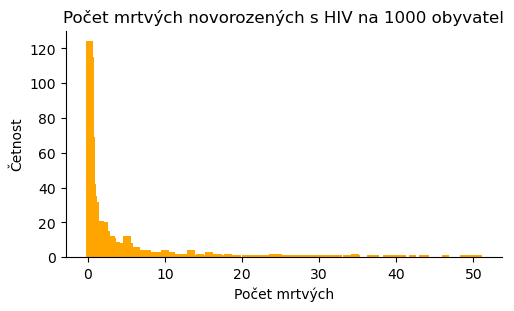

In [37]:
tmp = df[df["HIV/AIDS"] > 0.1]["HIV/AIDS"].value_counts()
# nastavení figure
fig = plt.figure(figsize=(5,3), facecolor='white', constrained_layout=True)
# přidání místa pro graf
ax = fig.add_subplot()
# přidání grafu
ax.bar(tmp.index, tmp.values, color='orange', width=1)
# přidání titulku
ax.set_title("Počet mrtvých novorozených s HIV na 1000 obyvatel")
# přidání popisků os
ax.set_xlabel("Počet mrtvých")
ax.set_ylabel("Četnost")
# odebrání zbytečných ohraničení
ax.spines['top'].set_visible(False) 
ax.spines['right'].set_visible(False)

GDP

In [38]:
tmp = "GDP"
print("Datový typ:", df[tmp].dtype)
print("Počet chybějících záznamů:", df[tmp].isnull().sum())
print("Počet unikátních hodnot:", df[tmp].nunique())
T = df[df[tmp].notnull()][tmp].sort_values().unique()
print("Rozsah hodnot:", T[0], "-", T[-1])
print("Průměr:", 7483)
print("Medián:", 1767)
df[tmp].describe()

Datový typ: float64
Počet chybějících záznamů: 443
Počet unikátních hodnot: 2485
Rozsah hodnot: 1.68135 - 119172.7418
Průměr: 7483
Medián: 1767


count      2485.000000
mean       7494.210719
std       14282.251492
min           1.681350
25%         463.852618
50%        1764.973870
75%        5932.899677
max      119172.741800
Name: GDP, dtype: float64

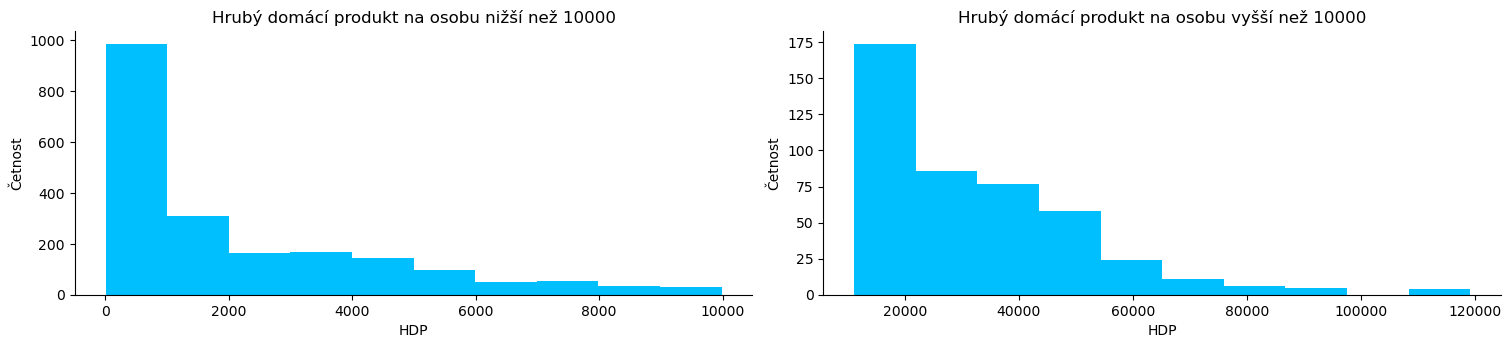

In [39]:
tmp1 = df[df["GDP"] <= 10000]["GDP"]
tmp2 = df[df["GDP"] > 10000]["GDP"]
fig = plt.figure(figsize=(15, 6), facecolor='white', constrained_layout=True)
# GRAF 1
# přidání místa pro graf
ax1 = fig.add_subplot(2, 2, 1)
# přidání grafu
ax1.hist(tmp1, color='deepskyblue')
# přidání titulku
ax1.set_title("Hrubý domácí produkt na osobu nižší než 10000")
# přidání popisků os
ax1.set_xlabel("HDP")
ax1.set_ylabel("Četnost")
# nastavení správného měřítka
# odebrání zbytečných ohraničení
ax1.spines['top'].set_visible(False) 
ax1.spines['right'].set_visible(False)
# GRAF 2
ax2 = fig.add_subplot(2, 2, 2)
# přidání grafu
ax2.hist(tmp2, color='deepskyblue')
# přidání titulku
ax2.set_title("Hrubý domácí produkt na osobu vyšší než 10000")
# přidání popisků os
ax2.set_xlabel("HDP")
ax2.set_ylabel("Četnost")
# nastavení správného měřítka
# odebrání zbytečných ohraničení
ax2.spines['top'].set_visible(False) 
ax2.spines['right'].set_visible(False)

Population

In [40]:
tmp = "Population"
print("Datový typ:", df[tmp].dtype)
print("Počet chybějících záznamů:", df[tmp].isnull().sum())
print("Počet unikátních hodnot:", df[tmp].nunique())
T = df[df[tmp].notnull()][tmp].sort_values().unique()
print("Rozsah hodnot:", T[0], "-", T[-1])
print("Průměr:", 12753380)
print("Medián:", 1386542)
df[tmp].describe()

Datový typ: float64
Počet chybějících záznamů: 644
Počet unikátních hodnot: 2277
Rozsah hodnot: 34.0 - 1293859294.0
Průměr: 12753380
Medián: 1386542


count    2.284000e+03
mean     1.276454e+07
std      6.103765e+07
min      3.400000e+01
25%      1.966738e+05
50%      1.391756e+06
75%      7.426746e+06
max      1.293859e+09
Name: Population, dtype: float64

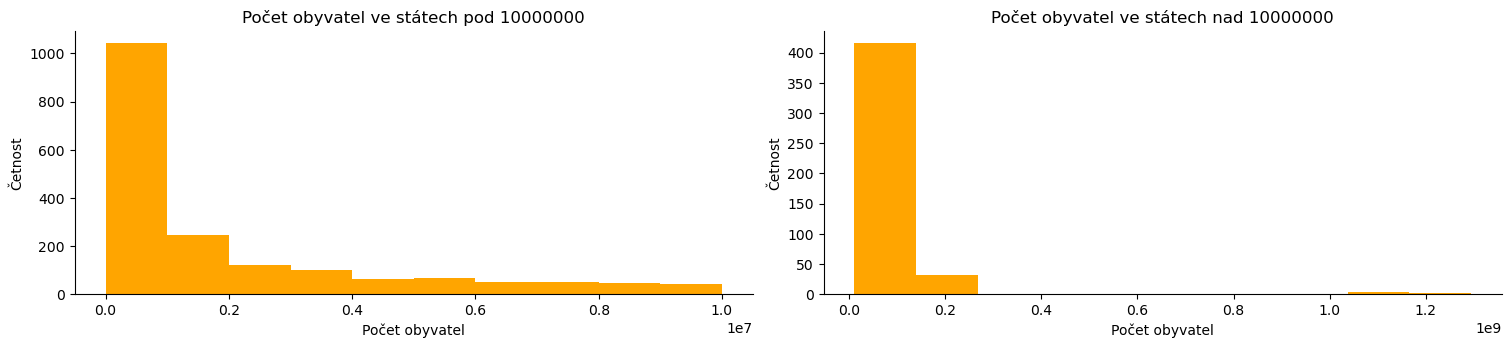

In [41]:
tmp1 = df[df["Population"] < 10000000]["Population"]
tmp2 = df[df["Population"] >= 10000000]["Population"]
# nastavení figure
fig = plt.figure(figsize=(15, 6), facecolor='white', constrained_layout=True)
# GRAF 1
# přidání místa pro graf
ax1 = fig.add_subplot(2, 2, 1)
# přidání grafu
ax1.hist(tmp1, color='orange')
# přidání titulku
ax1.set_title("Počet obyvatel ve státech pod 10000000")
# přidání popisků os
ax1.set_xlabel("Počet obyvatel")
ax1.set_ylabel("Četnost")
# nastavení správného měřítka
# odebrání zbytečných ohraničení
ax1.spines['top'].set_visible(False) 
ax1.spines['right'].set_visible(False)
# GRAF 2
ax2 = fig.add_subplot(2, 2, 2)
# přidání grafu
ax2.hist(tmp2, color='orange')
# přidání titulku
ax2.set_title("Počet obyvatel ve státech nad 10000000")
# přidání popisků os
ax2.set_xlabel("Počet obyvatel")
ax2.set_ylabel("Četnost")
# odebrání zbytečných ohraničení
ax2.spines['top'].set_visible(False) 
ax2.spines['right'].set_visible(False)

Thinness 1-19 years

In [42]:
tmp = "Thinness 1-19 Years"
print("Datový typ:", df[tmp].dtype)
print("Počet chybějících záznamů:", df[tmp].isnull().sum())
print("Počet unikátních hodnot:", df[tmp].nunique())
T = df[df[tmp].notnull()][tmp].sort_values().unique()
print("Rozsah hodnot:", T[0], "-", T[-1])
print("Průměr:", 4.83)
print("Medián:", 3.3)
df[tmp].describe()

Datový typ: float64
Počet chybějících záznamů: 32
Počet unikátních hodnot: 200
Rozsah hodnot: 0.1 - 27.7
Průměr: 4.83
Medián: 3.3


count    2896.000000
mean        4.850622
std         4.420829
min         0.100000
25%         1.600000
50%         3.300000
75%         7.200000
max        27.700000
Name: Thinness 1-19 Years, dtype: float64

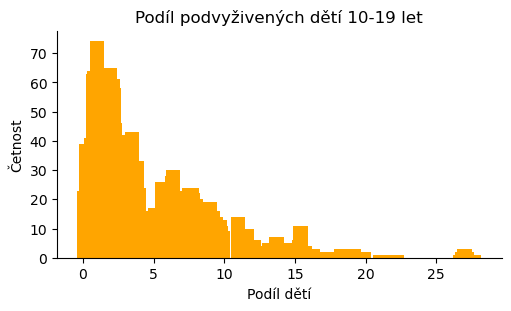

In [43]:
tmp = df["Thinness 1-19 Years"].value_counts()
# nastavení figure
fig = plt.figure(figsize=(5,3), facecolor='white', constrained_layout=True)
# přidání místa pro graf
ax = fig.add_subplot()
# přidání grafu
ax.bar(tmp.index, tmp.values, color='orange', width=1)
# přidání titulku
ax.set_title("Podíl podvyživených dětí 10-19 let")
# přidání popisků os
ax.set_xlabel("Podíl dětí")
ax.set_ylabel("Četnost")
# odebrání zbytečných ohraničení
ax.spines['top'].set_visible(False) 
ax.spines['right'].set_visible(False)

Thinness 5-9 years

In [44]:
tmp = "Thinness 5-9 Years"
print("Datový typ:", df[tmp].dtype)
print("Počet chybějících záznamů:", df[tmp].isnull().sum())
print("Počet unikátních hodnot:", df[tmp].nunique())
T = df[df[tmp].notnull()][tmp].sort_values().unique()
print("Rozsah hodnot:", T[0], "-", T[-1])
print("Průměr:", 4.87)
print("Medián:", 3.3)
df[tmp].describe()

Datový typ: float64
Počet chybějících záznamů: 32
Počet unikátních hodnot: 207
Rozsah hodnot: 0.1 - 28.6
Průměr: 4.87
Medián: 3.3


count    2896.000000
mean        4.881423
std         4.509609
min         0.100000
25%         1.575000
50%         3.400000
75%         7.200000
max        28.600000
Name: Thinness 5-9 Years, dtype: float64

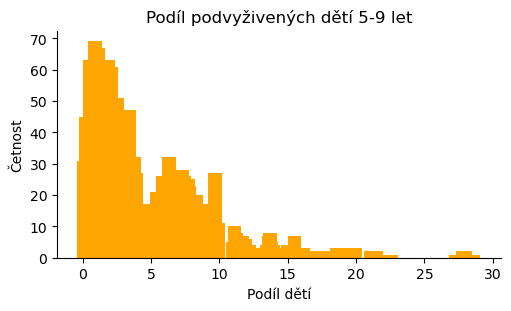

In [45]:
tmp = df["Thinness 5-9 Years"].value_counts()
# nastavení figure
fig = plt.figure(figsize=(5,3), facecolor='white', constrained_layout=True)
# přidání místa pro graf
ax = fig.add_subplot()
# přidání grafu
ax.bar(tmp.index, tmp.values, color='orange', width=1)
# přidání titulku
ax.set_title("Podíl podvyživených dětí 5-9 let")
# přidání popisků os
ax.set_xlabel("Podíl dětí")
ax.set_ylabel("Četnost")
# odebrání zbytečných ohraničení
ax.spines['top'].set_visible(False) 
ax.spines['right'].set_visible(False)

Income composition of resources

In [46]:
tmp = "Income Composition of Resources"
print("Datový typ:", df[tmp].dtype)
print("Počet chybějících záznamů:", df[tmp].isnull().sum())
print("Počet unikátních hodnot:", df[tmp].nunique())
T = df[df[tmp].notnull()][tmp].sort_values().unique()
print("Rozsah hodnot:", T[0], "-", T[-1])
print("Průměr:", 0.62)
print("Medián:", 0.67)
print("Podíl záznamů s indexem 0: {}%".format(round(len(df[df[tmp] == 0]) / len(df[tmp]) * 100, 1)))
df[tmp].describe()

Datový typ: float64
Počet chybějících záznamů: 160
Počet unikátních hodnot: 625
Rozsah hodnot: 0.0 - 0.948
Průměr: 0.62
Medián: 0.67
Podíl záznamů s indexem 0: 4.4%


count    2768.000000
mean        0.627419
std         0.210978
min         0.000000
25%         0.493000
50%         0.677000
75%         0.779250
max         0.948000
Name: Income Composition of Resources, dtype: float64

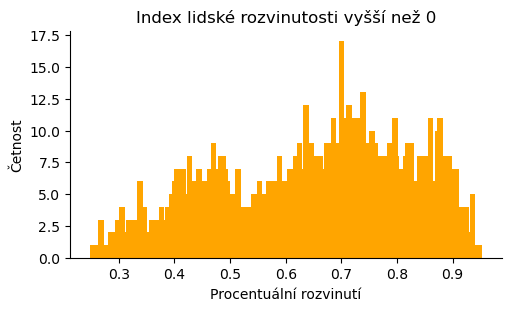

In [47]:
tmp = df[df["Income Composition of Resources"] > 0]["Income Composition of Resources"].value_counts()
# nastavení figure
fig = plt.figure(figsize=(5,3), facecolor='white', constrained_layout=True)
# přidání místa pro graf
ax = fig.add_subplot()
# přidání grafu
ax.bar(tmp.index, tmp.values, color='orange', width=0.01)
# přidání titulku
ax.set_title("Index lidské rozvinutosti vyšší než 0")
# přidání popisků os
ax.set_xlabel("Procentuální rozvinutí")
ax.set_ylabel("Četnost")
# odebrání zbytečných ohraničení
ax.spines['top'].set_visible(False) 
ax.spines['right'].set_visible(False)

Schooling

In [48]:
tmp = "Schooling"
print("Datový typ:", df[tmp].dtype)
print("Počet chybějících záznamů:", df[tmp].isnull().sum())
print("Počet unikátních hodnot:", df[tmp].nunique())
T = df[df[tmp].notnull()][tmp].sort_values().unique()
print("Rozsah hodnot:", T[0], "-", T[-1])
print("Průměr:", 12)
print("Medián:", 12.3)
df[tmp].describe()

Datový typ: float64
Počet chybějících záznamů: 160
Počet unikátních hodnot: 173
Rozsah hodnot: 0.0 - 20.7
Průměr: 12
Medián: 12.3


count    2768.000000
mean       11.999639
std         3.346440
min         0.000000
25%        10.100000
50%        12.300000
75%        14.300000
max        20.700000
Name: Schooling, dtype: float64

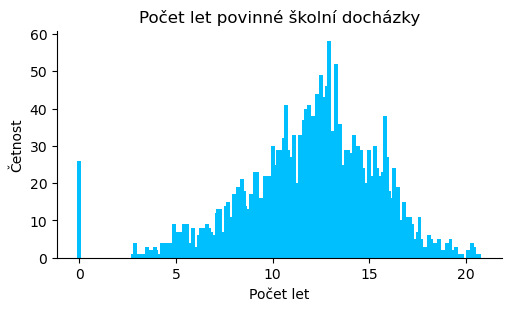

In [49]:
tmp = df["Schooling"].value_counts()
# nastavení figure
fig = plt.figure(figsize=(5,3), facecolor='white', constrained_layout=True)
# přidání místa pro graf
ax = fig.add_subplot()
# přidání grafu
ax.bar(tmp.index, tmp.values, color='deepskyblue', width=0.2)
# přidání titulku
ax.set_title("Počet let povinné školní docházky")
# přidání popisků os
ax.set_xlabel("Počet let")
ax.set_ylabel("Četnost")
# odebrání zbytečných ohraničení
ax.spines['top'].set_visible(False) 
ax.spines['right'].set_visible(False)

### Korelace

In [50]:
# změna stringu na hodnoty 0, 1
df["Status"] = df["Status"].astype('category').cat.codes

#### Heatmapa korelačních koeficientů

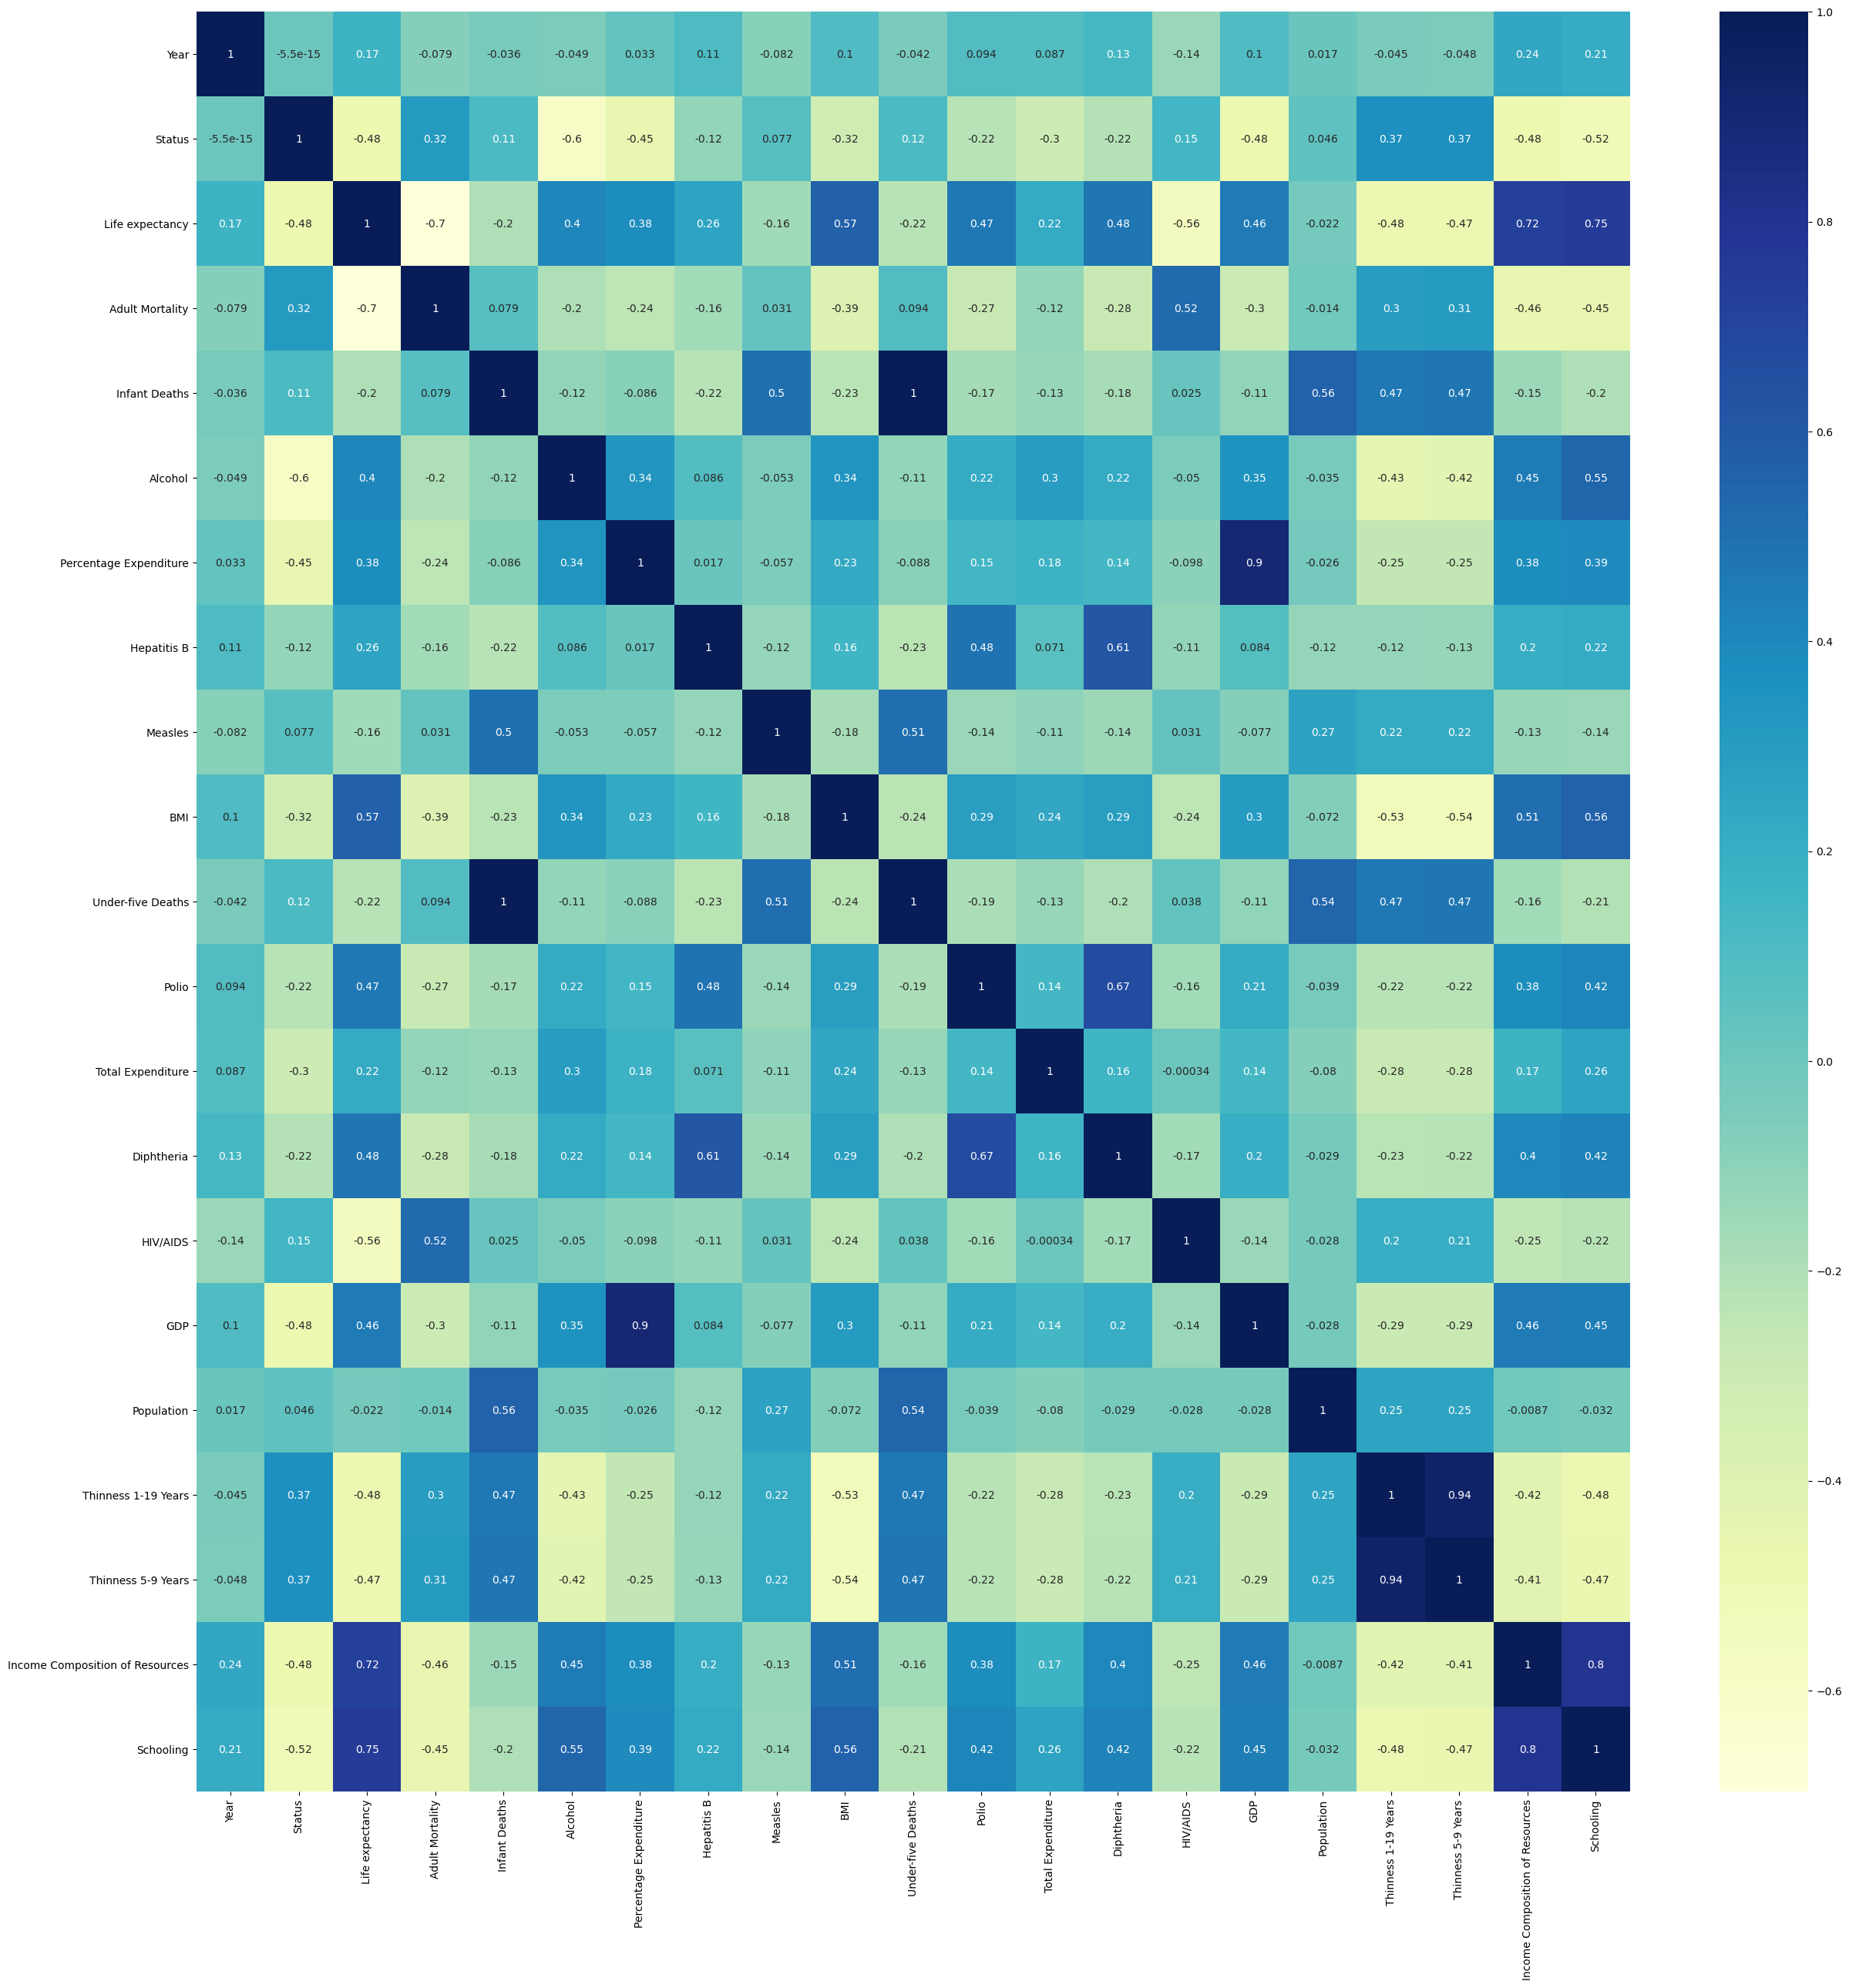

In [51]:
plt.figure(figsize=(30,30)) 
dataplot = sb.heatmap(df.corr(), cmap="YlGnBu", annot=True)
plt.savefig('plot1.eps')
plt.show()

#### Korelační koeficienty vůči vysvětlovanému příznaku

In [52]:
df.corr()["Life expectancy"].abs().sort_values(ascending=False)[1:]

Schooling                          0.751975
Income Composition of Resources    0.724776
Adult Mortality                    0.696359
BMI                                0.567694
HIV/AIDS                           0.556556
Status                             0.482136
Diphtheria                         0.479495
Thinness 1-19 Years                0.477183
Thinness 5-9 Years                 0.471584
Polio                              0.465556
GDP                                0.461455
Alcohol                            0.404877
Percentage Expenditure             0.381864
Hepatitis B                        0.256762
Under-five Deaths                  0.222529
Total Expenditure                  0.218086
Infant Deaths                      0.196557
Year                               0.170033
Measles                            0.157586
Population                         0.021538
Name: Life expectancy, dtype: float64

### Diskuse a motivace ke změnám

Rozdělení dat podle korelace s vysvětlovaným příznakem
K nim píšu příznaky, které s nimi mají vyšší korelační koeficient:

----------------
70-75%
* schooling - thinnesses, income, adult, alcohol, bmi, diphtheria, gdp
* income composition of resources - schooling, adult mortality, alcohol, bmi, diphtheria, gdp
* adult mortality - hiv/aids, income, schooling

----------------
38-55%
* bmi - thinnesses, income, schooling

* hiv - adult mortality
* status - alcohol, percentage expenditure, schooling, income
* thinnesses - infant deaths, Alcohol, bmi, under-five, income, schooling
* percentage expenditure - gdp
* diphteria - income, schooling, hepatitis
* polio - diptheria

* Alcohol - status, thinnesses, income, schooling
* GDP - percentage expenditure, income, schooling

----------------
< 25%
* infant deaths - measles, population, thinnesses, under-five
* hepatitis - polio, diphteria
* measles - under-five deaths
* under five - population, thinness, thinness

# Příprava dat

## Vyřešení problematických věcí

### Zahození nevhodných příznaků

* Sloupec Country je nominální a nemá žádné využití v této úloze, proto ho mohu odstranit

In [53]:
df.drop("Country", inplace=True, axis=1)

* u GDP chybí 400 záznamů a korelační koeficient s příznakem Percentage expenditure je 0.9, proto příznak GDP zahodím a budu využívat znalost z příznaku Percentage expenditure, navíc jediné další příznaky, se kterými má nějaký lepší korelační koeficient jsou Schooling a Income, které mají přímo vysoký korelační koeficient s vysvětlovaným

In [54]:
df.drop("GDP", inplace=True, axis=1)

* Příznaku population chybí 600 záznamů, navíc má velmi nízký korelační koeficient s vysvětlovaným a jediný další příznak, se kterým mý vyšší korelační koeficient(>0.5) je under-five deaths, který v datasetu nechám, proto ho můžu zahodit

In [55]:
df.drop("Population", inplace=True, axis=1)

* příznak Hepatitis chybí 500 záznamů a navíc velmi málo koreluje s vysvětlovanou proměnnou a velmi koreluje s příznaky Polio a Diphtheria se kterými budu dál pracovat, proto příznak zahodím

In [56]:
df.drop("Hepatitis B", inplace=True, axis=1)

příznaky infant deaths a under-five deaths mají společný korelační koeficient rovných 1, proto jeden mohu zahodit, korelační koeficient s vysvětlovaným příznakem mají pouze pod 25% procent a korelují pouze s příznaky ne příliš korelujícími s vysvětlovaným, vyjma příznaku thinness, ale stále pod 50%, ponechám pouze příznak under-five deaths

In [57]:
df.drop("Infant Deaths", inplace=True, axis=1)

* příznaku Alcohol chybí 10% dat a relativně silně koreluje s příznakem status a velmi podobně korelují s ostatními příznaky, proto jsem se rozhodl příznak alcohol zahodit

In [58]:
df.drop("Alcohol", inplace=True, axis=1)

* total expenditure má velmi nízký korelační koeficient se všemi příznaky včetně vysvětlovaného, navíc mu chybí 200 záznamů, proto ho také zahodím

In [59]:
# nevím co s chybějícími
df.drop("Total Expenditure", inplace=True, axis=1)

### Úprava hodnot

In [60]:
# snížení hodnot příznaku bez újmy na významu
df["Year"] = df["Year"] - 2000

### Tvorba nových příznaků

* příznaky thinness 1-19 a 5-9 years spolu téměř úplně korelují a korelační koeficienty s dalšími příznaky mají téměř totožné, proto je zkusím spojit v jeden příznak Thinnesses

In [61]:
df["Thinnesses"] = df["Thinness 1-19 Years"] + df["Thinness 5-9 Years"]
df.drop("Thinness 1-19 Years", inplace=True, axis=1)
df.drop("Thinness 5-9 Years", inplace=True, axis=1)

* příznaky poli a diphtheria spolu velice korelují, korelují úplně stejně s dalšími příznaky a významově si mají velice blízko. Abych zamezil linearitě, sloučím je do nového příznaku, který bude znamenat oba druhy očkování dohromady a příznaky sečtu

In [62]:
df["Vaccination"] = df["Polio"] + df["Diphtheria"]
df.drop("Polio", inplace=True, axis=1)
df.drop("Diphtheria", inplace=True, axis=1)

* příznaky schooling a Income Composition of Resources spolu velmi silně korelují a mají i velmi podobný vztah s dalšími příznaky, včetně vysvětlovaného se kterým mají dokonce nejsilnější korelaci ze všech. Proto je po znormování Schooling do intervalu 0-1 a spojím do jednoho

In [63]:
df["Income Composition of Resources"] = df["Income Composition of Resources"] * 20.7
df["Schooling + Income"] = df["Schooling"] + df["Income Composition of Resources"]
df.drop("Schooling", inplace=True, axis=1)
df.drop("Income Composition of Resources", inplace=True, axis=1)

### Chybějící hodnoty

* cca 200 chybějících hodnot ve sloupci Schooling + Income vyřeším odstraněním takových záznamů, protože pokusy o doplnění mediánem, nebo hodnotou z jiného sloupce dopadly špatně

In [64]:
df.dropna(inplace=True)

## Statistiky po provedení změn na datech

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2728 entries, 0 to 2937
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Year                    2728 non-null   int64  
 1   Status                  2728 non-null   int8   
 2   Life expectancy         2728 non-null   float64
 3   Adult Mortality         2728 non-null   float64
 4   Percentage Expenditure  2728 non-null   float64
 5   Measles                 2728 non-null   int64  
 6   BMI                     2728 non-null   float64
 7   Under-five Deaths       2728 non-null   int64  
 8   HIV/AIDS                2728 non-null   float64
 9   Thinnesses              2728 non-null   float64
 10  Vaccination             2728 non-null   float64
 11  Schooling + Income      2728 non-null   float64
dtypes: float64(8), int64(3), int8(1)
memory usage: 258.4 KB


In [66]:
df.corr()["Life expectancy"].abs().sort_values(ascending=False)[1:]

Schooling + Income        0.782656
Adult Mortality           0.680764
HIV/AIDS                  0.567654
BMI                       0.563037
Vaccination               0.500148
Status                    0.474968
Thinnesses                0.468205
Percentage Expenditure    0.395429
Under-five Deaths         0.205310
Year                      0.171849
Measles                   0.144091
Name: Life expectancy, dtype: float64

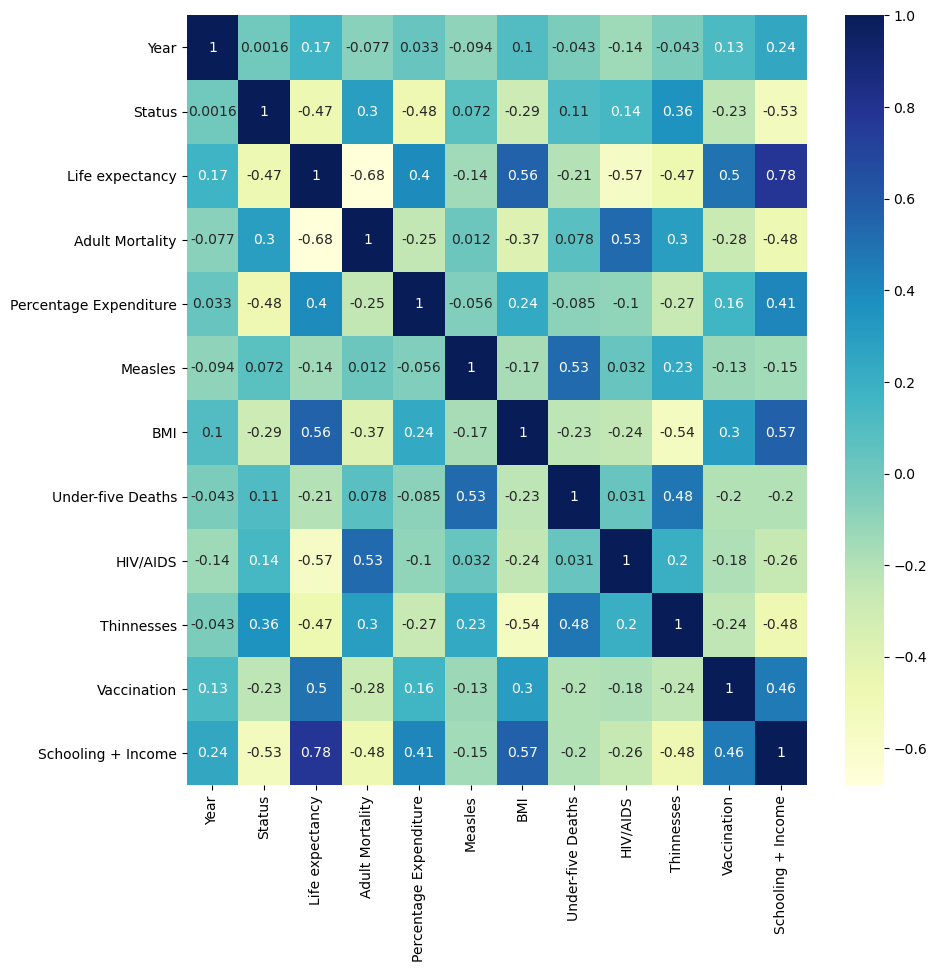

In [67]:
plt.figure(figsize=(10, 10)) 
dataplot = sb.heatmap(df.corr(), cmap="YlGnBu", annot=True)
plt.savefig('plot1.eps')
plt.show()

## Rozdělení dat

V poměru:                       
> 60% trénovací                                 
> 20% validační                                 
> 20% testovací                             

In [69]:
rd_seed = 254 # fixní random seed
Xdata = df.drop("Life expectancy", axis=1) # příznaky X
Ydata = df["Life expectancy"] # příznaky Y
# rozdělení do množin
Xtrain, Xtest, Ytrain, Ytest = train_test_split(Xdata, Ydata, test_size=0.4, random_state=rd_seed) 
Xval, Xtest, Yval, Ytest = train_test_split(Xtest, Ytest, test_size=0.5, random_state=rd_seed)

### Normalizace

In [70]:
scaler = StandardScaler()
Xtrain = scaler.fit_transform(Xtrain)
Xval = scaler.transform(Xval)
Xtest = scaler.transform(Xtest)

# Natrénování modelu

## Lineární regrese

Koeficienty natrénovaného modelu: [-0.11781365 -0.43049326 -2.02707778  0.58736438 -0.13340441  0.75384
 -0.21746621 -2.4178677  -0.14079417  1.19771947  4.06834613]
Intercept natrénovaného modelu: 69.91888753056234
Validační RMSE: 4.30824
Testovací RMSE: 3.93680
Validační MAE: 3.12473
Testovací MAE: 2.87475


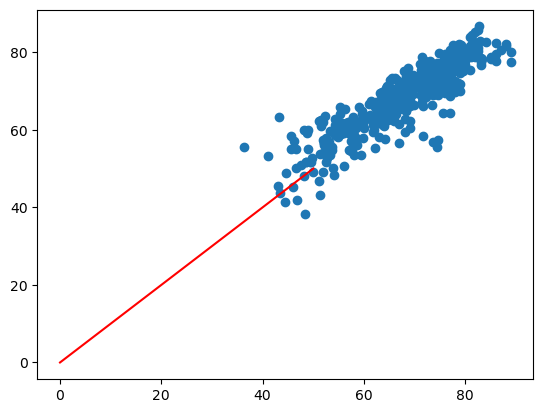

In [71]:
# trénování
clf_lin = LinearRegression()
clf_lin.fit(Xtrain, Ytrain)
Ypredict = clf_lin.predict(Xval)

# statistiky modelu
print("Koeficienty natrénovaného modelu:", clf_lin.coef_) # zobrazení koeficientů w
print("Intercept natrénovaného modelu:", clf_lin.intercept_)
RMSE_val_lin = mean_squared_error(Yval, clf_lin.predict(Xval), squared = False)
RMSE_test_lin = mean_squared_error(Ytest, clf_lin.predict(Xtest), squared = False)
MAE_val = mean_absolute_error(Yval, clf_lin.predict(Xval))
MAE_test = mean_absolute_error(Ytest, clf_lin.predict(Xtest))
print(f'Validační RMSE: {RMSE_val_lin:.5f}')
print(f'Testovací RMSE: {RMSE_test_lin:.5f}')
print(f'Validační MAE: {MAE_val:.5f}')
print(f'Testovací MAE: {MAE_test:.5f}')
plt.scatter(Yval, Ypredict)
plt.plot([0,50], [0,50], 'r')
plt.show()

## Hřebenová regrese

Koeficienty natrénovaného modelu: [-0.11654811 -0.43200471 -2.02742112  0.58768746 -0.13361169  0.75493442
 -0.21705983 -2.41643357 -0.14210402  1.1983069   4.06329043]
Intercept natrénovaného modelu: 69.91888753056234
Validační RMSE: 4.30832
Testovací RMSE: 3.93703
Validační MAE: 3.12511
Testovací MAE: 2.87511


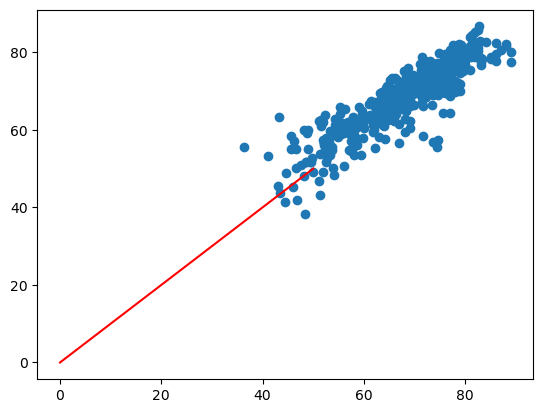

In [72]:
clf_ridge = Ridge()
clf_ridge.fit(Xtrain, Ytrain)
Ypredict = clf_ridge.predict(Xval)

# statistiky modelu
print("Koeficienty natrénovaného modelu:", clf_ridge.coef_) # zobrazení koeficientů w
print("Intercept natrénovaného modelu:", clf_ridge.intercept_)
RMSE_val_ridge = mean_squared_error(Yval, clf_ridge.predict(Xval), squared = False)
RMSE_test_ridge = mean_squared_error(Ytest, clf_ridge.predict(Xtest), squared = False)
MAE_val = mean_absolute_error(Yval, clf_ridge.predict(Xval))
MAE_test = mean_absolute_error(Ytest, clf_ridge.predict(Xtest))
print(f'Validační RMSE: {RMSE_val_ridge:.5f}')
print(f'Testovací RMSE: {RMSE_test_ridge:.5f}')
print(f'Validační MAE: {MAE_val:.5f}')
print(f'Testovací MAE: {MAE_test:.5f}')
plt.scatter(Yval, Ypredict)
plt.plot([0,50], [0,50], 'r')
plt.show()

## kNN / Regresní strom / Bázové funkce

In [73]:
clf_knn = KNeighborsRegressor()
clf_knn.fit(Xtrain, Ytrain)
Ypredict = clf_knn.predict(Xval)
print(f"Přesnost na validační množině: {clf_knn.score(Xval, Yval):0.4f}")
print(f"Přesnost na testovací množině: {clf_knn.score(Xtest, Ytest):0.4f}")

Přesnost na validační množině: 0.9114
Přesnost na testovací množině: 0.9015


In [74]:
# kNN - hyperparametry: k, vzdálenost, váhy

In [75]:
# bázové funkce = vyrobit nové příznaky transformací těch původních a z nich dělat regresi
# + regularizační člen

# Lazení hyperparametrů

* Hřebenová regrese

Nalezené minimum: 1.0


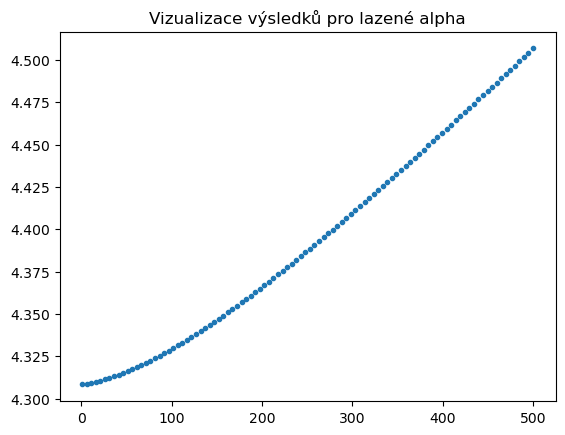

Validační RMSE: 4.30832
Testovací RMSE: 3.93703


In [76]:
def get_opt_ridge_model(Xtrain, Xval): # funkce vrací optimální model hřebenové regrese
    def ridgemodel_eval(alpha): # funkce pro zadané alpha vytvoří model a vrátí RMSE
        clf = Ridge(alpha=alpha)
        clf.fit(Xtrain, Ytrain)
        return mean_squared_error(Yval, clf.predict(Xval), squared = False)

    alphas = np.linspace(1,500,100) # vygenerování 100 různých aplha z intervalu 1:500
    alphas_res = [ridgemodel_eval(alpha) for alpha in alphas] # získání výsledků pro vygenerované alpha
    alphas_min = alphas[alphas_res.index(min(alphas_res))]
    print("Nalezené minimum:", alphas_min) # vybrání aplha s nejmenší chybou
    plt.plot(alphas, alphas_res, '.') # vizualizace výsledků
    plt.title("Vizualizace výsledků pro lazené alpha")
    plt.show()

    clf_opt = Ridge(alpha = alphas_min)
    clf_opt.fit(Xtrain, Ytrain)
    return clf_opt

clf_opt = get_opt_ridge_model(Xtrain, Xval)
RMSE_val_opt = mean_squared_error(Yval, clf_opt.predict(Xval), squared = False)
print(f'Validační RMSE: {RMSE_val_opt:.5f}')
RMSE_test_opt = mean_squared_error(Ytest, clf_opt.predict(Xtest), squared = False)
print(f'Testovací RMSE: {RMSE_test_opt:.5f}')

### Vybrání nejlepšího modelu podle RMSE

In [77]:
print("Lineární regrese:")
print(f'Validační RMSE: {RMSE_val_lin:.5f}')
print(f'Testovací RMSE: {RMSE_test_lin:.5f}')
print("Hřebenová regrese:")
print(f'Validační RMSE: {RMSE_val_ridge:.5f}')
print(f'Testovací RMSE: {RMSE_test_ridge:.5f}')
print("Vylazená hřebenová regrese:")
print(f'Validační RMSE: {RMSE_val_opt:.5f}')
print(f'Testovací RMSE: {RMSE_test_opt:.5f}')
models = {RMSE_test_lin:clf_lin, RMSE_test_ridge:clf_ridge, RMSE_test_opt:clf_opt}
best_RMSE = min(list(models.keys()))
best_model = models[min(list(models.keys()))]

Lineární regrese:
Validační RMSE: 4.30824
Testovací RMSE: 3.93680
Hřebenová regrese:
Validační RMSE: 4.30832
Testovací RMSE: 3.93703
Vylazená hřebenová regrese:
Validační RMSE: 4.30832
Testovací RMSE: 3.93703


## Odhad RMSE a MAE na nových datech

In [78]:
print("Odhad na nových datech pomocí nejlepšího modelu podle RMSE na testovacích datech je:")
best_RMSE = mean_squared_error(Ytest, clf_ridge.predict(Xtest), squared = False)
best_MAE = mean_absolute_error(Ytest, clf_ridge.predict(Xtest))
print("RMSE: {}".format(best_RMSE))
print("MAE: {}".format(best_MAE))

Odhad na nových datech pomocí nejlepšího modelu podle RMSE na testovacích datech je:
RMSE: 3.937029782884573
MAE: 2.8751081313739584


### Zdroje:
ML1, VIZ,

https://www.kaggle.com/datasets/kumarajarshi/life-expectancy-who?datasetId=12603

https://www.kaggle.com/code/raianand1991/analysis